# Regression and Data Analysis in Python
This tutorial focuses on some basic tools for regression analysis and data visualization available in Python. The main tools are Pandas and StatsModels. Pandas is a powerful data storage engine built in a combination of C++ (for speed) and Python (for accessiblity). StatsModels is a Python package developed by a group of econometricians that implements a variety of regression and discrete choice models. We will also show some basic plotting functionalities using matplotlib.

The dataset used in this tutorial is Q4 bikeshare data for the City of Toronto. We link this data with weather data to provide additional explanatory variables. The data is essentially imported to Python with no pre-processing to show the ability of Python to handle these tasks. We must first import the necessary Python packages.

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
import seaborn as sns
sns.set()  # use Seaborn styles. 

We can now import the two datasets from csv files using Pandas. This package can also import STATA, shapefile, and a wide variety of other formats with minimal effort.

In [2]:
dfB = pd.read_csv('../Data/2016_Bike_Share_Toronto_Ridership_Q4.csv',sep=',')
dfW = pd.read_csv('../Data/weather_2016_Q4.csv',sep=',')
dfB.head()

,trip_id,trip_start_time,trip_stop_time,trip_duration_seconds,from_station_name,to_station_name,user_type
0,462305,1-10-16 0:00,1-10-16 0:07,394,Queens Quay W / Dan Leckie Way,Fort York Blvd / Garrison Rd,Casual
1,462306,1-10-16 0:00,1-10-16 0:09,533,Sherbourne St / Wellesley St,Edward St / Yonge St,Member
2,462307,1-10-16 0:00,1-10-16 0:07,383,Queens Quay W / Dan Leckie Way,Fort York Blvd / Garrison Rd,Casual
3,462308,1-10-16 0:01,1-10-16 0:27,1557,Cherry St / Distillery Ln,Fort York Blvd / Capreol Crt,Casual
4,462309,1-10-16 0:01,1-10-16 0:27,1547,Cherry St / Distillery Ln,Fort York Blvd / Capreol Crt,Casual


In [3]:
dfB.tail()

,trip_id,trip_start_time,trip_stop_time,trip_duration_seconds,from_station_name,to_station_name,user_type
217564,712377,31/12/2016 23:26,31/12/2016 23:39,824,Union Station,Gould St / Mutual St,Member
217565,712378,31/12/2016 23:26,31/12/2016 23:34,478,Bay St / College St (East Side),Beverly St / Dundas St W,Member
217566,712379,31/12/2016 23:33,31/12/2016 23:38,271,Temperance St / Yonge St,Victoria St / Gould St (Ryerson University),Member
217567,712380,31/12/2016 23:37,31/12/2016 23:58,1253,Christie St / Benson Ave (Wychwood Barns),Wellesley St E / Yonge St Green P,Member
217568,712381,31/12/2016 23:40,31/12/2016 23:48,478,Ted Rogers Way / Bloor St E,St George St / Bloor St W,Member


It is clear that the 'trip_start_time' column in the bikeshare data does not have a consistent data-time format. We also want to breakup the date and time into components to facilitate easy of data analysis. This could be done in a spreadsheet, but Pandas provides a way to convert the data into a consistent datetime format, even with multiple input datetime formats (as in our case). The same process can be used for the weather data.

In [4]:
dfB.loc[:, 'trip_start_time'] = pd.to_datetime(dfB['trip_start_time'])
dfB.loc[:, 'trip_stop_time'] = pd.to_datetime(dfB['trip_stop_time'])
dfW.loc[:, 'date_time'] = pd.to_datetime(dfW['date_time'])

Once thde data are converted to a consistent datetime format, the indivual components can be put in their own columns within the Pandas dataframe.

In [5]:
dfB.loc[:, 'trip_month'] = dfB['trip_start_time'].dt.month
dfB.loc[:, 'trip_start_hour'] = dfB['trip_start_time'].dt.hour
dfB.loc[:, 'day_of_week'] = dfB['trip_start_time'].dt.dayofweek
dfB.loc[:, 'trip_date'] = dfB['trip_start_time'].dt.date
dfW.loc[:, 'weather_date'] = dfW['date_time'].dt.date

Pandas includes a variety of dataframe joining methods. The .merge() function functions similar to a database operation, allowing for left, right, inner, and outer joins. In the next line of code, we join the bikeshare and weather data on the date.

In [33]:
df = pd.merge(dfB, dfW, left_on='trip_date', right_on='weather_date')
df = df.dropna(subset=['trip_start_hour','temp','wind_spd'])
df.head()

,trip_id,trip_start_time,trip_stop_time,trip_duration_seconds,from_station_name,to_station_name,user_type,trip_month,trip_start_hour,day_of_week,...,visibility,visibility flag,stn press (kPa),stn press flag,hmdx,hmdx Flag,wind chill,wind chill flag,weather,weather_date
0,501394,2016-10-10,2016-10-10 00:27:00,1597,Essex St / Christie St,Danforth Ave / Ellerbeck St,Member,10,0,0,...,16.1,NaN,101.97,NaN,NaN,NaN,NaN,NaN,NaN,2016-10-10
1,501394,2016-10-10,2016-10-10 00:27:00,1597,Essex St / Christie St,Danforth Ave / Ellerbeck St,Member,10,0,0,...,16.1,NaN,101.98,NaN,NaN,NaN,NaN,NaN,NaN,2016-10-10
2,501394,2016-10-10,2016-10-10 00:27:00,1597,Essex St / Christie St,Danforth Ave / Ellerbeck St,Member,10,0,0,...,16.1,NaN,102.03,NaN,NaN,NaN,NaN,NaN,NaN,2016-10-10
3,501394,2016-10-10,2016-10-10 00:27:00,1597,Essex St / Christie St,Danforth Ave / Ellerbeck St,Member,10,0,0,...,16.1,NaN,102.03,NaN,NaN,NaN,NaN,NaN,NaN,2016-10-10
4,501394,2016-10-10,2016-10-10 00:27:00,1597,Essex St / Christie St,Danforth Ave / Ellerbeck St,Member,10,0,0,...,16.1,NaN,102.06,NaN,NaN,NaN,NaN,NaN,NaN,2016-10-10


Our new dataframe has the following columns.

In [34]:
df.columns

Index(['trip_id', 'trip_start_time', 'trip_stop_time', 'trip_duration_seconds',
       'from_station_name', 'to_station_name', 'user_type', 'trip_month',
       'trip_start_hour', 'day_of_week', 'trip_date', 'date_time', 'year',
       'month', 'day', 'time', 'temp', 'temp flag', 'dew point',
       'dew point flag', 'rel_hum', 'rel hum flag', 'wind dir (10s degrees)',
       'wind dir flag', 'wind_spd', 'wind speed flag', 'visibility',
       'visibility flag', 'stn press (kPa)', 'stn press flag', 'hmdx',
       'hmdx Flag', 'wind chill', 'wind chill flag', 'weather',
       'weather_date'],
      dtype='object')

## Basic OLS model

Writing models using StatsModels is quite straightforward. It is made easier using the patsy function syntax used below. This includes the ability to write regression models in standard text using the column names from the dataframe.

StatsModels provides an extensive output, including the R-squared, AIC, BIC, and log likelihood. The R-squared in this first model is very low. We can probably do better.

In [35]:
mod = smf.ols(formula='trip_duration_seconds ~ trip_start_hour + temp + wind_spd', data=df)
res = mod.fit()
print(res.summary())

                              OLS Regression Results                             
Dep. Variable:     trip_duration_seconds   R-squared:                       0.004
Model:                               OLS   Adj. R-squared:                  0.004
Method:                    Least Squares   F-statistic:                     4193.
Date:                   Thu, 02 Jun 2022   Prob (F-statistic):               0.00
Time:                           14:28:36   Log-Likelihood:            -2.6773e+07
No. Observations:                3284246   AIC:                         5.355e+07
Df Residuals:                    3284242   BIC:                         5.355e+07
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept   

The patsy syntax allows us to define categorical variables by simply enclosing a dataframe column name in C(). We include additional user, temporal, and weather data in this model. It is likely that trip length will vary by the weather and user type.

In [36]:
mod = smf.ols(formula='trip_duration_seconds ~ C(user_type) + C(day_of_week) + trip_start_hour + temp + wind_spd + rel_hum', data=df)
res = mod.fit()
print(res.summary())

                              OLS Regression Results                             
Dep. Variable:     trip_duration_seconds   R-squared:                       0.138
Model:                               OLS   Adj. R-squared:                  0.138
Method:                    Least Squares   F-statistic:                 4.785e+04
Date:                   Thu, 02 Jun 2022   Prob (F-statistic):               0.00
Time:                           14:28:58   Log-Likelihood:            -2.6536e+07
No. Observations:                3284246   AIC:                         5.307e+07
Df Residuals:                    3284234   BIC:                         5.307e+07
Df Model:                             11                                         
Covariance Type:               nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

This is a better fit, but still not fantastic. We can print statistics on the dataframe using the .describe() function.

In [37]:
df.describe()

,trip_id,trip_duration_seconds,trip_month,trip_start_hour,day_of_week,year,month,day,temp,temp flag,...,rel hum flag,wind dir (10s degrees),wind_spd,visibility,stn press (kPa),stn press flag,hmdx,hmdx Flag,wind chill,wind chill flag
count,3.284246e+06,3.284246e+06,3.284246e+06,3.284246e+06,3.284246e+06,3284246.0,3.284246e+06,3.284246e+06,3.284246e+06,0.0,...,0.0,3.150433e+06,3.284246e+06,3.284246e+06,3.284246e+06,0.0,55924.000000,0.0,465023.000000,0.0
mean,5.985200e+05,7.500344e+02,1.070217e+01,1.503079e+01,2.777930e+00,2016.0,1.070217e+01,1.945613e+01,7.540466e+00,NaN,...,NaN,2.121335e+01,1.751053e+01,1.509810e+01,1.008337e+02,NaN,26.311101,NaN,-9.169824,NaN
std,6.352197e+04,8.413695e+02,7.316588e-01,6.777563e+00,1.923553e+00,0.0,7.316588e-01,6.354890e+00,6.530756e+00,NaN,...,NaN,9.338412e+00,9.697334e+00,3.031381e+00,8.039912e-01,NaN,0.943341,NaN,3.783297,NaN
min,5.013940e+05,6.000000e+01,1.000000e+01,0.000000e+00,0.000000e+00,2016.0,1.000000e+01,1.000000e+01,-1.110000e+01,NaN,...,NaN,1.000000e+00,0.000000e+00,4.000000e-01,9.876000e+01,NaN,25.000000,NaN,-20.000000,NaN
25%,5.406470e+05,3.940000e+02,1.000000e+01,1.200000e+01,1.000000e+00,2016.0,1.000000e+01,1.400000e+01,3.600000e+00,NaN,...,NaN,1.200000e+01,1.100000e+01,1.610000e+01,1.002500e+02,NaN,26.000000,NaN,-11.000000,NaN
50%,6.106360e+05,5.940000e+02,1.100000e+01,1.600000e+01,3.000000e+00,2016.0,1.100000e+01,1.900000e+01,7.400000e+00,NaN,...,NaN,2.400000e+01,1.500000e+01,1.610000e+01,1.008600e+02,NaN,26.000000,NaN,-8.000000,NaN
75%,6.501320e+05,8.800000e+02,1.100000e+01,2.100000e+01,4.000000e+00,2016.0,1.100000e+01,2.500000e+01,1.220000e+01,NaN,...,NaN,2.900000e+01,2.400000e+01,1.610000e+01,1.014700e+02,NaN,27.000000,NaN,-6.000000,NaN
max,7.123810e+05,1.439100e+04,1.200000e+01,2.300000e+01,6.000000e+00,2016.0,1.200000e+01,3.100000e+01,2.270000e+01,NaN,...,NaN,3.600000e+01,6.100000e+01,1.610000e+01,1.030900e+02,NaN,28.000000,NaN,-2.000000,NaN


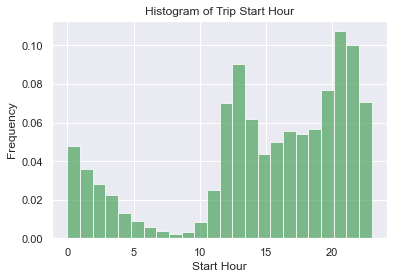

In [38]:
plt.hist(df['trip_start_hour'], len(df['trip_start_hour'].unique()), density=True, facecolor='g', alpha=0.75)
plt.xlabel('Start Hour');
plt.ylabel('Frequency');
plt.title('Histogram of Trip Start Hour');

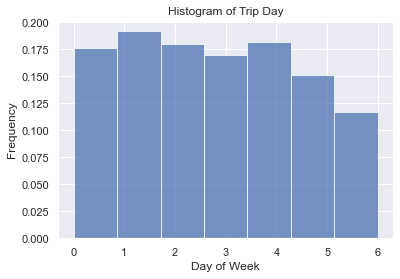

In [39]:
plt.hist(df['day_of_week'], len(df['day_of_week'].unique()), density=True, facecolor='b', alpha=0.75)
plt.xlabel('Day of Week');
plt.ylabel('Frequency');
plt.title('Histogram of Trip Day');

## Multicollinearity - Condition number
One way to assess multicollinearity is to compute the condition number. Values over 20 are worrisome (see Greene 4.9). The first step is to normalize the independent variables to have unit length.

In [42]:
names = ['trip_start_hour', 'temp', 'wind_spd', 'rel_hum']
X = df.loc[:, names]
norm_x = X.values
for i, name in enumerate(X):
    if name == "const":
        continue
    norm_x[:, i] = X[name] / np.linalg.norm(X[name])
norm_xtx = np.dot(norm_x.T, norm_x)

Then, we take the square root of the ratio of the biggest to the smallest eigen values.

In [43]:
eigs = np.linalg.eigvals(norm_xtx)
condition_number = np.sqrt(eigs.max() / eigs.min())
print(condition_number)

6.081828344074039


It seems multicollinearity is not an issue here.

## Normality of residuals
### Jarque-Bera test

In [49]:
name = ["Jarque-Bera", "Chi^2 two-tail prob.", "Skew", "Kurtosis"]
test = sms.jarque_bera(res.resid)
lzip(name, test)

[('Jarque-Bera', 1115712248.24051),
 ('Chi^2 two-tail prob.', 0.0),
 ('Skew', 7.601629761266371),
 ('Kurtosis', 92.00592479723178)]

### Omni test

In [50]:
name = ["Chi^2", "Two-tail probability"]
test = sms.omni_normtest(res.resid)
lzip(name, test)

[('Chi^2', 4373754.830439826), ('Two-tail probability', 0.0)]

Residuals are not normally distributed for this model.

## Heteroskedasticity tests
### Breush-Pagan test

In [51]:
name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test = sms.het_breuschpagan(res.resid, res.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 157728.47807392376),
 ('p-value', 0.0),
 ('f-value', 15062.277811009506),
 ('f p-value', 0.0)]

### Goldfeld-Quandt test

In [52]:
name = ["F statistic", "p-value"]
test = sms.het_goldfeldquandt(res.resid, res.model.exog)
lzip(name, test)

[('F statistic', 0.5255813700234377), ('p-value', 0.9999999999999999)]

The Breush-Pagan test suggests the residuals are heteroskedastic but the Goldfeld-Quandt suggests they are not. It is not uncommon to get conflicting results from tests.